In [1]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve
import math
from IPython.core.display import display, HTML
import pandas as pd
import numpy as np
from numpy import mean
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
display(HTML("<style>.container { width:100% !important; }</style>"))

Using TensorFlow backend.


In [2]:


# In[ ]:

pd.set_option("display.max_columns", None)


def preprocess(data, number_of_airports_included = 10, number_of_airlines_included = 10):

    def clean_variables_no_info(data):
        """
        Description: drops columns that provide no information
        :param data: flights dataframe
        :return: returns cleaned dataframe
        """

        NAs_to_remove = ["Unnamed: 15"]

        cleaned_data = data.drop(NAs_to_remove, axis=1)

        return cleaned_data


    def round_hours(data):
      
        data.dropna(subset=["CRS_DEP_TIME"], inplace=True)
        return_hour(data)
        
        return data

    def return_hour(data):
        my_list = []
      

        for x in data["CRS_DEP_TIME"]:
            a = math.floor(x / 100) -1
            my_list.append(a)
      
        data["TIME"] = my_list
        data = data.drop(["CRS_DEP_TIME"], axis=1)

        return data

    def select_number_of_airports(data, number_of_airports_included):

        main_origins = data[["ORIGIN", "DEST"]].groupby(["ORIGIN"]).count().sort_values(
            by="DEST", ascending=False).head(number_of_airports_included).reset_index()["ORIGIN"]

        main_dests = data[["DEST", "ORIGIN"]].groupby(["DEST"]).count().sort_values(
            by="ORIGIN", ascending=False).head(number_of_airports_included).reset_index()["DEST"]

        data = data[data["ORIGIN"].isin(main_origins) & data["DEST"].isin(main_dests)]

        return data

    def select_number_of_airlines(data, number_of_airlines_included):

        main_airlines = data[["OP_CARRIER", "DEST"]].groupby(["OP_CARRIER"]).count().sort_values(by="DEST", ascending=False).head(
            number_of_airlines_included).reset_index()["OP_CARRIER"]

        data = data[data["OP_CARRIER"].isin(main_airlines)]

        return data

    def extra_features(data):
        
        data['avg_tax_out'] = data.groupby(['OP_CARRIER', 'ORIGIN'])['TAXI_OUT'].transform('mean')
        data['avg_tax_out'] = MinMaxScaler().fit_transform(data[['avg_tax_out']])
        data['avg_tax_out'] = data['avg_tax_out'].where(data['avg_tax_out'] < .7, .7)*142
        data['avg_tax_in'] = data.groupby(['OP_CARRIER', 'DEST'])['TAXI_IN'].transform('mean')
        data['avg_tax_in'] = MinMaxScaler().fit_transform(data[['avg_tax_in']])
        data['avg_tax_in'] = data['avg_tax_in'].where(data['avg_tax_in'] < .2, .2)*500
        data['airline_delay'] = data["DEP_DELAY_NEW"]-data["TAXI_OUT"]
        data['airline_delay'] = data.groupby(['OP_CARRIER', 'ORIGIN'])['airline_delay'].transform('mean')
        data['airline_delay'] = MinMaxScaler().fit_transform(data[['airline_delay']])
        data['airline_delay'] = data['airline_delay'].where(data['airline_delay'] < .25, .25)*500
        return data
    
    def dummy_generator(data):    
        dum_orig = pd.get_dummies(data["ORIGIN"], prefix="origin").astype(int)
        
        dum_dest = pd.get_dummies(data["DEST"], prefix="dest").astype(int)
        
        dum_air = pd.get_dummies(data["OP_CARRIER"], prefix="airline")
        
        dum_orig = dum_orig.drop(['origin_ATL'], axis=1)
        dum_dest = dum_dest.drop(['dest_ATL'], axis=1)  
        dum_air = dum_air.drop(['airline_WN'], axis=1)
        
        data = pd.concat([data, dum_orig,dum_dest,dum_air], axis=1)
        return data



    data = clean_variables_no_info(data)                                                       
    data = round_hours(data)
    data = select_number_of_airports(data, number_of_airports_included)
    data = select_number_of_airports(data, number_of_airlines_included)
    data = extra_features(data)
    data = dummy_generator(data)


    data.drop(["DEP_DEL15", "CRS_DEP_TIME",  "CRS_ARR_TIME",
                "TAXI_OUT", "TAXI_IN",'MONTH',
               "ACTUAL_ELAPSED_TIME", "CRS_ARR_TIME", "DEP_DELAY_NEW", "ARR_DELAY_NEW", "DISTANCE"],
              axis=1, inplace=True)
    data.drop(["OP_CARRIER", "ORIGIN","DEST"],
              axis=1, inplace=True)
    data = data.dropna()
    data['ARR_DEL15']=data['ARR_DEL15'].astype(int)

    return data

data_jan = pd.read_csv("2019_jan_flights.csv")
data_feb = pd.read_csv("2019_feb_flights.csv")
data_mar = pd.read_csv("2019_mar_flights.csv")
data_apr = pd.read_csv("2019_apr_flights.csv")
data_may = pd.read_csv("2019_may_flights.csv")
data_jun = pd.read_csv("2019_jun_flights.csv")
data_jul = pd.read_csv("2019_jul_flights.csv")
data_aug = pd.read_csv("2019_aug_flights.csv")
data_sep = pd.read_csv("2019_sep_flights.csv")
data_oct = pd.read_csv("2019_oct_flights.csv")
data_nov = pd.read_csv("2019_nov_flights.csv")
data_dec = pd.read_csv("2019_dec_flights.csv")

data = pd.concat([data_jan, data_feb, data_mar, data_apr, data_may, data_jun, data_jul, data_aug, data_sep, data_oct, data_nov, data_dec], ignore_index = True)



data = preprocess(data)
#data = data.sample(50000)
data.head()


,DAY_OF_WEEK,ARR_DEL15,TIME,avg_tax_out,avg_tax_in,airline_delay,origin_CLT,origin_DEN,origin_DFW,origin_IAH,origin_LAX,origin_LGA,origin_ORD,origin_PHX,origin_SFO,dest_CLT,dest_DEN,dest_DFW,dest_IAH,dest_LAX,dest_LGA,dest_ORD,dest_PHX,dest_SFO,airline_9E,airline_AA,airline_AS,airline_DL,airline_EV,airline_F9,airline_MQ,airline_NK,airline_OH,airline_OO,airline_UA,airline_YV,airline_YX
2079,5,0,5,21.931499,31.592411,67.189227,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2080,5,0,7,21.931499,31.592411,67.189227,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2081,5,0,9,21.931499,31.592411,67.189227,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2082,5,0,17,21.931499,31.592411,67.189227,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2083,5,0,12,21.931499,31.592411,67.189227,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:


X = data.drop(['ARR_DEL15'], axis=1).values
y = data['ARR_DEL15'].values



In [4]:

def plot_cm(classifier, predictions):
    cm = confusion_matrix(y_test, predictions)
    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['No_delay','Delay']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), 
                     horizontalalignment='center', color='White')
    
    plt.show()
        
    tn, fp, fn, tp = cm.ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    F1 = 2*recall*precision/(recall+precision)

    print('Recall={0:0.3f}'.format(recall),'\nPrecision={0:0.3f}'.format(precision))
    print('F1={0:0.3f}'.format(F1))

def plot_aucprc(classifier, scores):
    precision, recall, _ = precision_recall_curve(y_test, scores, pos_label=0)
    average_precision = average_precision_score(y_test, scores)

    print('Average precision-recall score: {0:0.3f}'.format(
          average_precision))

    plt.plot(recall, precision, label='area = %0.3f' % average_precision, color="green")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc="best")
    plt.show()

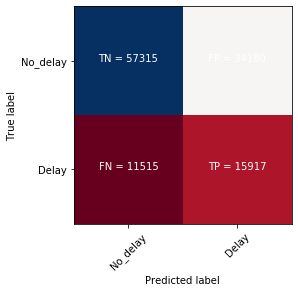

Recall=0.580 
Precision=0.318
F1=0.411
Average precision-recall score: 0.342


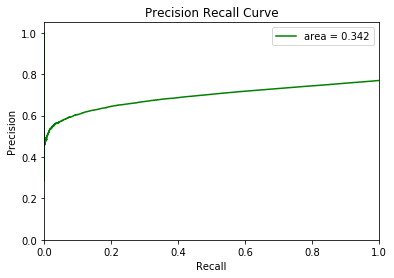

In [53]:

sampler = SMOTETomek(sampling_strategy=0.85, random_state=42,n_jobs =2)

model = XGBClassifier(random_state = 42,
                      n_jobs = 4,
                      scale_pos_weight =1.25,
                      learning_rate =0.024,
                      n_estimators=1000,
                      max_depth = 7,
                      min_child_weight = 1,
                      gamma=0.4,
                      subsample=0.85,
                      colsample_bytree=0.95,
                      reg_alpha=0.005,
                      objective= 'binary:logistic',
                      seed=42)

steps = [('sampler', sampler), ('model', model)]

pipeline = Pipeline(steps=steps)
X_train, X_test, y_train, y_test = tts(X, y, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
try:
    scores = pipeline.decision_function(X_test)
except:
    scores = pipeline.predict_proba(X_test)[:,1]

#Make plots
plot_cm(pipeline, y_pred)
plot_aucprc(pipeline, scores)



In [54]:
import pickle
pickle.dump(pipeline, open("flights.pickle.dat", "wb"))

In [ ]:
Below the method of finding optimal xgb params

In [ ]:
smt = SMOTETomek(sampling_strategy=1, random_state=42,n_jobs =2)
X_res, y_res = smt.fit_resample(X, y)
X_train, X_test, y_train, y_test= tts(X_res, y_res, random_state=42)

In [ ]:

xgb1 = XGBClassifier(
    learning_rate =0.1, n_estimators=1000,
    max_depth=5, min_child_weight=1, gamma=0,subsample=0.8,colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4,scale_pos_weight=1,seed=27)
# modelfit(xgb1, train, train_X)
xgb1.fit(X_train, y_train)



In [ ]:
y_pred = xgb1.predict(X_test)
try:
    scores = xgb1.decision_function(X_test)
except:
    scores = xgb1.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
recall = tp / (tp + fn)
precision = tp / (tp + fp)
F1 = 2*recall*precision/(recall+precision)
print('Recall={0:0.3f}'.format(recall),'\nPrecision={0:0.3f}'.format(precision))
print('F1={0:0.3f}'.format(F1))
print(cm)

In [ ]:

param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
                                                  n_estimators=1000, 
                                                  max_depth=5,
                                                  min_child_weight=1,
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=2, scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, 
                        scoring='roc_auc',
                        n_jobs=2,
                        iid=False, 
                        cv=2)

gsearch1.fit(X_train,y_train)
gsearch1.best_params_

In [ ]:
param_test3 = { 
    'gamma':[i/10.0 for i in range(0,5)] 
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
                                                  n_estimators=1000, 
                                                  max_depth = 7,
                                                  min_child_weight = 1,
                                                  gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=2, scale_pos_weight=1,seed=27), 
                        param_grid = param_test3, 
                        scoring='roc_auc',
                        n_jobs=2,
                        iid=False, 
                        cv=2)

gsearch3.fit(X_train,y_train)
gsearch3.best_params_



In [ ]:
param_test4 = {
    'subsample':[i/100.0 for i in range(85,100,5)],
    'colsample_bytree':[i/100.0 for i in range(85,100,5)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=1000, 
                                                  max_depth = 7,
                                                  min_child_weight = 1,
                                                  gamma=0.4, 
                                                  subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=2, scale_pos_weight=1,seed=27), 
                        param_grid = param_test4, 
                        scoring='roc_auc',
                        n_jobs=2,
                        iid=False, 
                        cv=2)

gsearch4.fit(X_train,y_train)
gsearch4.best_params_

In [ ]:
param_test6 = {
 'learning_rate':[i/1000.0 for i in range(22,30,2)]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.024, 
                                                  n_estimators=1000, 
                                                  gamma=0.4,
                                                  subsample=0.85,
                                                  colsample_bytree=0.95,
                                                  max_depth = 7,
                                                  min_child_weight = 1,
                                                  objective= 'binary:logistic', nthread=2, scale_pos_weight=1,seed=27), 
                        param_grid = param_test6, 
                        scoring='roc_auc',
                        n_jobs=2,
                        iid=False, 
                        cv=2)

gsearch6.fit(X_train,y_train)
gsearch6.best_params_